In [1]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, annotations, feature_extractor, train=True):
        #ann_file = os.path.join(annotations, "custom_train.json" if train else "custom_val.json")
        ann_file = os.path.join(annotations, "coco_labels.json")

        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor
        
        # TODO: change all the labels to start at 1
        # remove person/pit/door
        # we just want safety vest and hard hat
        # add area


    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}

        for i in range(len(target['annotations'])):
            target['annotations'][i]['area'] = 0
        # exclude data with negative categories
        target['annotations'] = [item for item in target['annotations'] if item['category_id'] > 0 ]
        

        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target


/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import DetrFeatureExtractor

DATASETPATH="/home/tim_voxelai_com/data/coco_uscold_all_class/uscold/denton/truck_doors_22_32/cha/20210224_093148/"
VALDATASETPATH="/home/tim_voxelai_com/data/coco_uscold_all_class/uscold/denton/truck_doors_22_32/cha/20210224_093148_lower_445_upper_455/"

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=DATASETPATH,annotations=DATASETPATH,   feature_extractor=feature_extractor)
# for now the val set is the training set
val_dataset = CocoDetection(img_folder=VALDATASETPATH, annotations=VALDATASETPATH,feature_extractor=feature_extractor, train=False)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [3]:
len(train_dataset)


268

Image n°5200
images/frame_5200.jpg
{0: {'id': 0, 'name': 'PERSON'}, 1: {'id': 1, 'name': 'PIT'}, 2: {'id': 2, 'name': 'HARD_HAT'}, 3: {'id': 3, 'name': 'SAFETY_VEST'}}
25
4


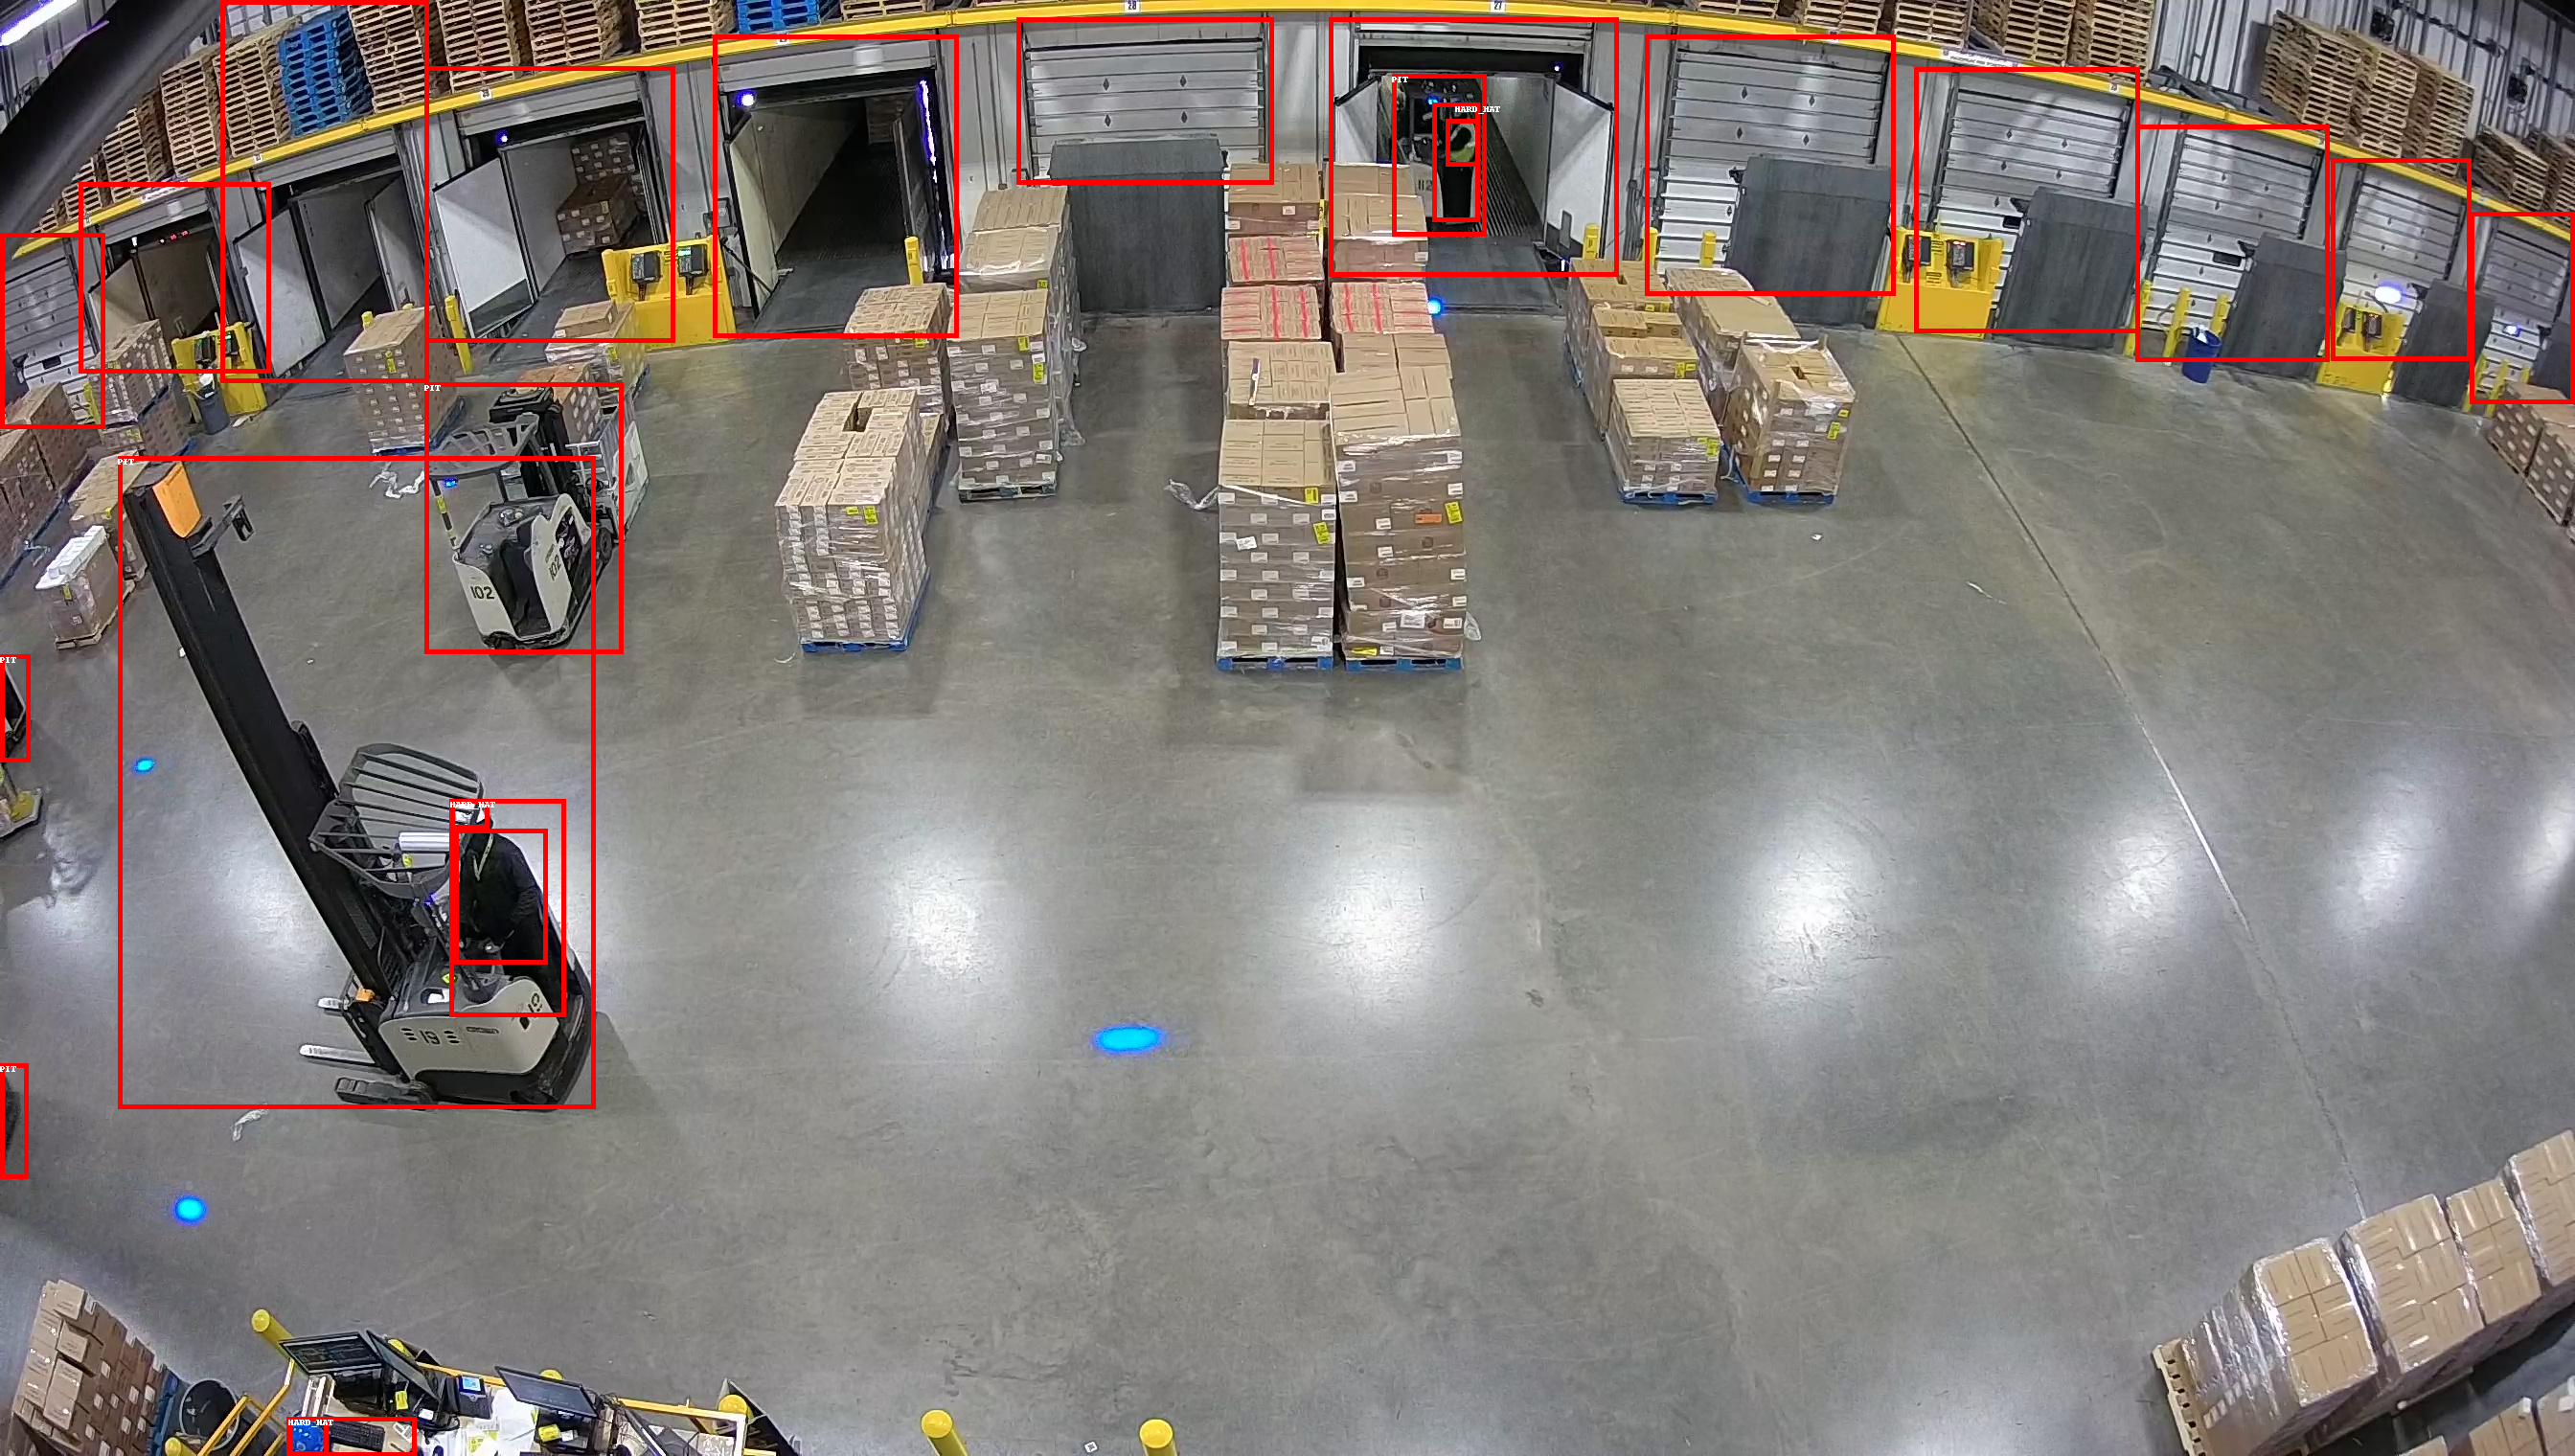

In [4]:
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[51]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
print(image['file_name'])

image = Image.open(os.path.join(DATASETPATH, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
print(cats)
print(len(annotations))
id2label = {k: v['name'] for k,v in cats.items()}
print(len(id2label))
for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  #print(class_idx)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=5)
  if class_idx > 0:
     draw.text((x, y), id2label[class_idx], fill='white')


image

In [5]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2, num_workers=8)
batch = next(iter(train_dataloader))

In [16]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=4,
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

model = Detr(lr=9e-5, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from pytorch_lightning import Trainer

trainer = Trainer(gpus=1, min_epochs=5, max_epochs=30)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.040   Total estimated model params size (MB)


Epoch 0:  43%|████▎     | 67/156 [00:58<01:17,  1.15it/s, loss=3.24, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 1:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.38, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.21, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  72%|███████▏  | 112/156 [01:08<00:26,  1.64it/s, loss=2.21, v_num=24]


Epoch 3:  18%|█▊        | 28/156 [00:30<02:17,  1.07s/it, loss=2.2, v_num=24] 

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7fc55b2160>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 65:   3%|▎         | 4/156 [10:35<6:42:17, 158.80s/it, loss=4.02, v_num=23]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f80cbfddcf8>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  19%|█▉        | 30/156 [00:31<02:13,  1.06s/it, loss=2.16, v_num=24]

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7fc55b2160>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 65:   3%|▎         | 4/156 [10:36<6:43:23, 159.23s/it, loss=4.02, v_num=23]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f80cbfddcf8>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  24%|██▎       | 37/156 [00:37<02:01,  1.02s/it, loss=2.23, v_num=24]

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7fc55b2160>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 65:   3%|▎         | 4/156 [10:42<6:47:11, 160.73s/it, loss=4.02, v_num=23]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f80cbfddcf8>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  26%|██▌       | 40/156 [00:40<01:56,  1.01s/it, loss=2.25, v_num=24]

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7fc55b2160>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 65:   3%|▎         | 4/156 [10:45<6:48:50, 161.38s/it, loss=4.02, v_num=23]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f80cbfddcf8>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  27%|██▋       | 42/156 [00:42<01:54,  1.00s/it, loss=2.25, v_num=24]

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7fc55b2160>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 65:   3%|▎         | 4/156 [10:47<6:49:55, 161.81s/it, loss=4.02, v_num=23]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f80cbfddcf8>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  28%|██▊       | 43/156 [00:42<01:52,  1.00it/s, loss=2.24, v_num=24]

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7fc55b2160>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 65:   3%|▎         | 4/156 [10:48<6:50:26, 162.02s/it, loss=4.02, v_num=23]


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f80cbfddcf8>>
Traceback (most recent call last):
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/tim_voxelai_com/ws/second/experimental/twroge/detection/detr/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  44%|████▎     | 68/156 [01:03<01:21,  1.07it/s, loss=2.66, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 4:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.18, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.29, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  72%|███████▏  | 112/156 [01:08<00:26,  1.64it/s, loss=2.29, v_num=24]


Epoch 6:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=1.92, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.29, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.16, v_num=24] 


Validating: 0it [00:00, ?it/s]
Epoch 9:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=1.91, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 10:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.4, v_num=24] 
Validating: 0it [00:00, ?it/s]
Validating:  51%|█████     | 45/89 [00:10<00:09,  4.84it/s]


Epoch 11:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.15, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 12:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.11, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████| 156/156 [01:17<00:00,  2.01it/s, loss=2.11, v_num=24]


Epoch 13:  44%|████▎     | 68/156 [00:58<01:15,  1.16it/s, loss=2.31, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 14:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.2, v_num=24]  
Validating: 0it [00:00, ?it/s]
Epoch 15:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.13, v_num=24]
Validating: 0it [00:00, ?it/s]
Validating:  48%|████▊     | 43/89 [00:09<00:09,  4.90it/s]


Epoch 16:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.33, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 17:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=1.94, v_num=24] 
Validating: 0it [00:00, ?it/s]
Validating:  98%|█████████▊| 87/89 [00:18<00:00,  4.93it/s]


Epoch 18:  44%|████▎     | 68/156 [00:58<01:15,  1.16it/s, loss=2.11, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 19:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=1.65, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 20:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=1.92, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 20:  69%|██████▉   | 108/156 [01:07<00:29,  1.60it/s, loss=1.92, v_num=24]


Epoch 21:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=1.85, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 22:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=1.89, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 22:  97%|█████████▋| 152/156 [01:16<00:02,  1.99it/s, loss=1.89, v_num=24]


Epoch 23:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=1.86, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 24:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=1.6, v_num=24]  
Validating: 0it [00:00, ?it/s]
Epoch 25:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.52, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 25:  68%|██████▊   | 106/156 [01:06<00:31,  1.58it/s, loss=2.52, v_num=24]


Epoch 26:  44%|████▎     | 68/156 [00:58<01:15,  1.16it/s, loss=2.01, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 27:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=2.1, v_num=24]  
Validating: 0it [00:00, ?it/s]
Validating:  93%|█████████▎| 83/89 [00:18<00:01,  4.90it/s]


Epoch 28:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=1.87, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 29:  44%|████▎     | 68/156 [00:58<01:15,  1.17it/s, loss=1.79, v_num=24] 
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████| 156/156 [01:18<00:00,  1.98it/s, loss=1.79, v_num=24]


In [34]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

pixel_values, target = train_dataset[1]

In [9]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 754, 1333])


In [10]:
# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [11]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    print(out_bbox)
    print(size)
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if boxes:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [31]:
def visualize_predictions(image, outputs, threshold=0.55):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  print(probas)
  print(probas.shape)
  keep = probas.max(-1).values > threshold
  if any(keep):
       # convert predicted boxes from [0; 1] to image scales
       print(outputs.pred_boxes[0, keep].cpu())
       bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
  else:
    bbox_scaled = None
  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

tensor([[0.4423, 0.1565, 0.1038, 0.1501],
        [0.3577, 0.1777, 0.1482, 0.1620],
        [0.5030, 0.1299, 0.0719, 0.0976],
        [0.2400, 0.1141, 0.2565, 0.1741],
        [0.4294, 0.1383, 0.1516, 0.1089],
        [0.4223, 0.1521, 0.1140, 0.0980],
        [0.5050, 0.1161, 0.0985, 0.1041],
        [0.4368, 0.1599, 0.0717, 0.0753],
        [0.4203, 0.1601, 0.1045, 0.0901],
        [0.4246, 0.1548, 0.1040, 0.1081],
        [0.3748, 0.1489, 0.1297, 0.1887],
        [0.5502, 0.0999, 0.0833, 0.0881],
        [0.3863, 0.1406, 0.1586, 0.1839],
        [0.2802, 0.1531, 0.1846, 0.2037],
        [0.3981, 0.1594, 0.1022, 0.1510],
        [0.3108, 0.1174, 0.1379, 0.1141],
        [0.3437, 0.1612, 0.1636, 0.1180],
        [0.1852, 0.0924, 0.3034, 0.2329],
        [0.1953, 0.1030, 0.2890, 0.1990],
        [0.5332, 0.1280, 0.0860, 0.0878],
        [0.4502, 0.1438, 0.1394, 0.1607],
        [0.3595, 0.1346, 0.1671, 0.1588],
        [0.3711, 0.1033, 0.1374, 0.1257],
        [0.4347, 0.1349, 0.0908, 0

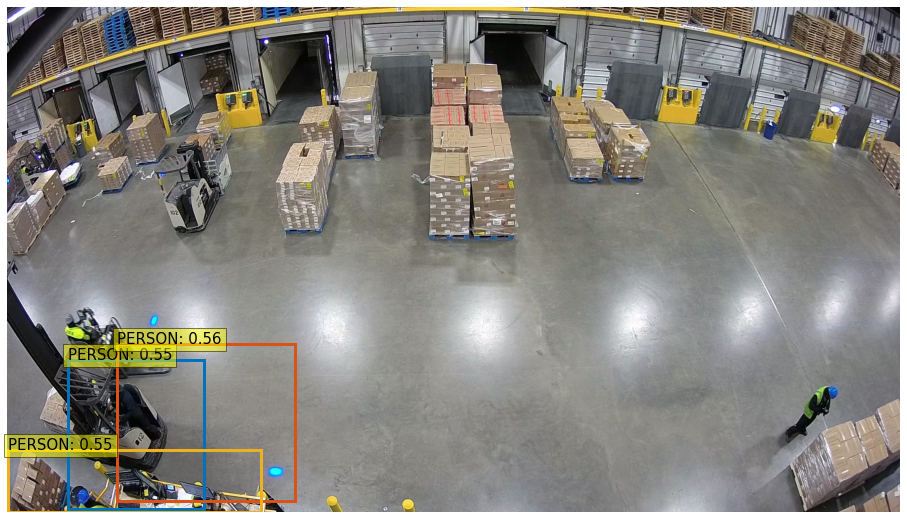

In [35]:
image_id = target['image_id'].item()
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(DATASETPATH, image['file_name']))

visualize_predictions(image, outputs)